In [1]:
# First try to use the data to train a model
import numpy as np
import random
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed, Bidirectional, BatchNormalization
from keras import regularizers
from keras.optimizers import SGD
import pandas as pd
import matplotlib as mpl
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import math
from tensorflow.keras import regularizers
import gc
from sklearn.metrics import r2_score

print(tf.config.experimental.list_physical_devices('GPU'))

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


In [2]:
# Load the dataset from the file

SensorValues = pd.read_csv('mySensorData.csv', header = None)
LocationValues = pd.read_csv('myLocationData.csv', header = None)
# SortedVal = pd.read_csv('mySortedVal.csv', header = None)
# SortedTest = pd.read_csv('mySortedTest.csv', header = None)

# SensorValues.head()
# LocationValues.head()
# SortedValues.head()

sensor_arr = SensorValues.values
location_arr = LocationValues.values
# sorted_val= SortedVal.values
# sorted_test= SortedTest.values

print(sensor_arr.shape)
print(location_arr.shape)
# # print(sorted_val.shape)
# # print(sorted_test.shape)

print(np.min(sensor_arr))
print(np.max(sensor_arr))


(3200000, 480)
(3200000, 3)
-0.000864
0.001386


In [3]:
def min_max_scaler(data):
    # Calculate the minimum and maximum values of the data
    
    min_val = np.min(data)
    max_val = np.max(data)
    
    scaled_data = (data - min_val) / (max_val - min_val)
    
    return scaled_data

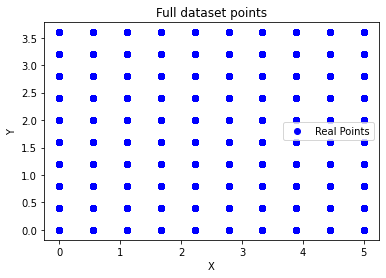

In [4]:
# Preview the Location of the real data points

plt.scatter(location_arr[:,0], location_arr[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Full dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()
        


In [5]:
train_size_per = 80    # 70% of the data is used for training
                        # 15% of the data is used for validation
                        # 15% of the data is used for testing
rotation_per_position = 16

reads_per_position = 2000   

total_values_per_position = rotation_per_position * reads_per_position              


X = min_max_scaler(sensor_arr)
Y_loc_0 = (location_arr[:,0])
Y_loc_1 = (location_arr[:,1])
Y_rot = (location_arr[:,2])

Y = np.zeros((Y_loc_0.shape[0], 3))

for i in range(0, Y_loc_0.shape[0]):
    Y[i,0] = Y_loc_0[i]
    Y[i,1] = Y_loc_1[i]
    Y[i,2] = Y_rot[i]


data_sen_size = int(X.shape[0])
data_sen_size_2 = int(X.shape[1])

data_loc_size = int(Y.shape[0])
data_loc_size_2 = int(Y.shape[1])



val_size = int(data_sen_size * (((100 - train_size_per)/100) * 1/2))
test_size = int(data_sen_size * (((100 - train_size_per)/100) * 1/2))
train_size = int(data_sen_size * (train_size_per/100))

print("train_size: ", train_size)
print("val_size: ", val_size)
print("test_size: ", test_size)



train_size:  2560000
val_size:  320000
test_size:  320000


In [6]:
data_size_rotation = int(data_sen_size / total_values_per_position)

val_test_size_per = int(data_size_rotation * ((100 - train_size_per)/100))

random_numbers = random.sample(range(0, data_size_rotation), val_test_size_per)

random.shuffle(random_numbers)

halfway = len (random_numbers) // 2
print(halfway)

test_random = random_numbers[:halfway]
val_random = random_numbers[halfway:]

print(val_size)

val_numbers = np.zeros((val_size, 1))
test_numbers = np.zeros((test_size, 1))

n_val = 0
for i in val_random:
    for j in range(0, total_values_per_position):
        val_numbers[n_val] = i * total_values_per_position + j
        n_val = n_val + 1

n_test = 0
for i in test_random:
    for j in range(0, total_values_per_position):
        test_numbers[n_test] = i * total_values_per_position + j
        n_test = n_test + 1
        
val_sorted = np.sort(val_numbers, axis=0)
test_sorted = np.sort(test_numbers, axis=0)

10
320000


In [7]:
import csv
# with open('mySortedVal.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     for row in val_sorted:
#         writer.writerow(row)
     
# with open('mySortedTest.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     for row in test_sorted:
#         writer.writerow(row)   

SortedVal = pd.read_csv('mySortedVal.csv', header = None)
SortedTest = pd.read_csv('mySortedTest.csv', header = None)

val_sorted= SortedVal.values
test_sorted= SortedTest.values

In [8]:
X_train = np.zeros((train_size, data_sen_size_2))
Y_train = np.zeros((train_size, data_loc_size_2))

X_val = np.zeros((val_size, data_sen_size_2))
Y_val = np.zeros((val_size, data_loc_size_2))

X_test = np.zeros((test_size, data_sen_size_2))
Y_test = np.zeros((test_size, data_loc_size_2))

n_test = 0
n_train = 0
n_val = 0

for i in range (0, data_sen_size):
    percentage = i / data_sen_size * 100
    # print("Progress: " + str(percentage) + "%")    
    if i in val_sorted:
        X_val[n_val] = X[i]
        Y_val[n_val] = Y[i]
        n_val = n_val + 1
    elif i in test_sorted:
        X_test[n_test] = X[i]
        Y_test[n_test] = Y[i]
        n_test = n_test + 1
    else:
        X_train[n_train] = X[i]
        Y_train[n_train] = Y[i]
        n_train = n_train + 1

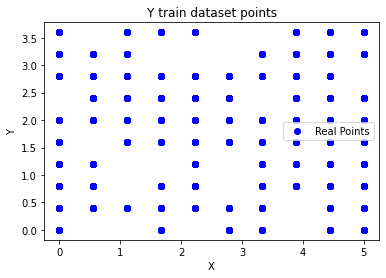

In [9]:
# Split the data into training and testing sets
plt.scatter(Y_train[:,0], Y_train[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y train dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

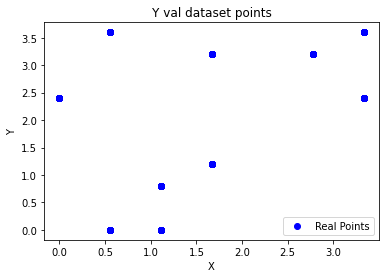

In [10]:
plt.scatter(Y_val[:,0], Y_val[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y val dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

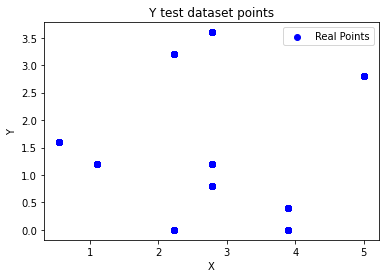

In [11]:
plt.scatter(Y_test[:,0], Y_test[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y test dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

C:\Users\win10\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


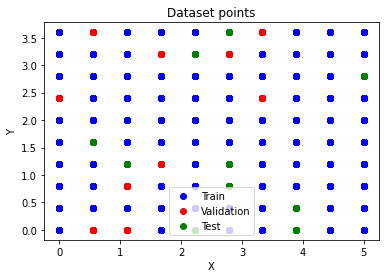

In [12]:
plt.scatter(Y_train[:,0], Y_train[:,1], color='blue', label='Train')
plt.scatter(Y_val[:,0], Y_val[:,1], color='red', label='Validation')
plt.scatter(Y_test[:,0], Y_test[:,1], color='green', label='Test')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [13]:
# Machine Learning - Loss Functions for X and Y

def loss_function_xy(y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = tf.reduce_mean(K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true)))
    return distance

In [14]:
# Machine Learning - Metric Functions for X and Y

def xy_metric (y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = tf.reduce_mean(K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true)))
    return distance

In [15]:
# Machine Learning - Loss Functions for theta

def loss_function_theta(y_true, y_pred):
    theta_true = y_true
    theta_pred = y_pred
    return tf.reduce_mean(tf.abs(theta_true - theta_pred))

In [16]:
# Machine Learning - Metric Functions for theta

def theta_metric (y_true, y_pred):
    theta_true = y_true
    theta_pred = y_pred
    return tf.reduce_mean(tf.abs(theta_true - theta_pred))

In [17]:
# Machine Learning - Loss Functions for X, Y 

def huber_loss(y_true, y_pred, delta=1.0):
    # Calculate absolute error
    abs_error = K.abs(y_true - y_pred)

    # Calculate the loss for small errors (MSE)
    small_error_loss = 0.5 * K.square(abs_error)
    
    # Calculate the loss for large errors (MAE)
    large_error_loss = delta * (abs_error - 0.5 * delta)

    # Use the MSE loss for errors below delta, and MAE loss for errors above delta
    huber_loss = K.mean(tf.where(abs_error <= delta, small_error_loss, large_error_loss))
    
    return huber_loss

In [18]:
def mae_metric(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)

In [19]:
# Machine Learning - Loss Functions for theta (radians)

def huber_loss_radians(y_true, y_pred, delta=1.0):
    # Calculate absolute error
    abs_error = K.abs(y_true - y_pred)

    # Calculate the loss for small errors (MSE)
    small_error_loss = 0.5 * K.square(abs_error)
    
    # Calculate the loss for large errors (MAE)
    large_error_loss = delta * (abs_error - 0.5 * delta)

    # Use the MSE loss for errors below delta, and MAE loss for errors above delta
    huber_loss = K.mean(tf.where(abs_error <= delta, small_error_loss, large_error_loss))
    
    return huber_loss

In [20]:
# Machine Learning - Circular MAE for theta (in radians)

def circular_mae_radians(y_true, y_pred):
    # Calculate the circular absolute error
    error_rad = tf.abs(tf.atan2(tf.sin(y_true - y_pred), tf.cos(y_true - y_pred)))

    # Calculate the mean circular absolute error
    circular_mae = tf.reduce_mean(error_rad, axis=-1)
    
    return circular_mae

In [21]:
#Early Stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,  # Stop training if no improvement after 10 epochs
    restore_best_weights=True  # Restore the best model weights
)

In [22]:
#Model Checkpoint

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=True,
    monitor='val_loss',
)

In [23]:
# Learning Rate Schedule

def lr_schedule(epoch):
    if epoch < 5:
        return 0.0001
    elif epoch < 25:
        return 0.00001
    elif epoch < 50:
        return 0.000001
    elif epoch < 75:
        return 0.0000001
    else:
        return 0.00000001
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [24]:
# TensorBoard Logging

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True,
)

In [25]:

# Machine Learning - Scikit-optimizer

# search_space = [ 
#                 Categorical(['relu', 'tanh'], name='activation'), 
#                 Real(1e-5, 1e-2, name='learning_rate'), 
#                 Real(1e-5, 1e-2, name='alpha')]
                

# @use_named_args(search_space)
# def objective(activation, learning_rate, alpha):
#     model = MLPRegressor(hidden_layer_sizes=(range(1, 1029), range(1, 1029), range(1, 1029), range(1, 1029)), alpha = alpha , activation=activation, learning_rate_init = learning_rate, max_iter=5000, early_stopping=True, validation_fraction=0.2, n_iter_no_change=50, tol=0.0001, random_state=42)
#     # model.fit(X_train, Y_train)

#     scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')
    
#     # Calculate the mean of the negative mean squared error
#     mean_mse = np.mean(-scores)
    

#     return mean_mse

# result = gp_minimize(objective, search_space, n_calls=100, random_state=42, verbose=10)

# print("Best parameters: hidden_layer_sizes = %d, activation = %s, learning_rate = %.6f" % (res.x[0], res.x[1], res.x[2]))


In [26]:
# print("Best parameters: hidden_layer_sizes = %d, activation = %s, learning_rate = %.6f" % (result.x[0], result.x[1], result.x[2]))
# print("Best score = %.4f" % (result.fun))
# print("Best Loss = %.4f" % (result.fun))

print(data_sen_size_2)

480


In [27]:
# randomize the data

data = list(zip(X_train, Y_train))
random.shuffle(data)

X_train, Y_train = zip(*data)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [28]:
# print(X[200])

# print(Y)

In [29]:
# print(Y[200])

In [30]:
# Machine Learning - Build the model

inputs = tf.keras.Input(shape=(data_sen_size_2,))

# x = tf.keras.layers.Dense(480, activation='relu')(inputs)
# x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dense(480, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.Dense(480, activation='relu')(x)
x = tf.keras.layers.Dense(480, activation='relu')(inputs)
# x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization layer
# x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout layer with a dropout rate of 0.5
x = tf.keras.layers.Dense(1440, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization layer
# x = tf.keras.layers.Dropout(0.1)(x)  # Add Dropout layer with a dropout rate of 0.5
x = tf.keras.layers.Dense(1440, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization layer
x = tf.keras.layers.Dense(480, activation='relu')(x)
# kernel_regularizer=tf.keras.regularizers.l2(0.01)
xy_output = tf.keras.layers.Dense(2, activation='linear', name='xy')(x)
theta_output = tf.keras.layers.Dense(1, activation='linear', name='theta')(x)

model = tf.keras.Model(inputs=inputs, outputs=[xy_output, theta_output])

model.summary()

optimizer = Adam(learning_rate=0.00001)
# model.compile(loss = 'SparseCategori', optimizer = 'adam', metrics = ['accuracy'])
model.compile(optimizer = optimizer, loss = {'xy': huber_loss, 'theta': huber_loss_radians}, loss_weights={'xy': 0.7, 'theta': 0.3}, metrics = {'xy': mae_metric, 'theta': circular_mae_radians})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 480)          230880      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 860)          413660      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 860)          740460      ['dense_1[0][0]']                
                                                                                              

In [31]:
gc.collect()

385

In [32]:
# Machine Learning - Train the model
predict = model.fit(
    X_train, 
    {
        "xy": Y_train[:, :2], 
        "theta": Y_train[:, 2]
    }, 
    validation_data=(X_val, {"xy": Y_val[:, :2], "theta": Y_val[:, 2]}), 
    epochs=100, 
    batch_size=32, 
    verbose = 1, 
    callbacks=[
        model_checkpoint,
        lr_scheduler,
        early_stopping
    ]
    )

Epoch 1/100
80000/80000 [==============================] - 238s 3ms/step - loss: 0.1315 - xy_loss: 0.0158 - theta_loss: 0.1719 - xy_mae_metric: 0.1326 - theta_circular_mae_radians: 0.3483 - val_loss: 0.0773 - val_xy_loss: 0.0123 - val_theta_loss: 0.1974 - val_xy_mae_metric: 0.1260 - val_theta_circular_mae_radians: 0.2890 - lr: 1.0000e-04
Epoch 2/100
80000/80000 [==============================] - 229s 3ms/step - loss: 0.0352 - xy_loss: 0.0081 - theta_loss: 0.0723 - xy_mae_metric: 0.1007 - theta_circular_mae_radians: 0.1951 - val_loss: 0.0460 - val_xy_loss: 0.0110 - val_theta_loss: 0.1052 - val_xy_mae_metric: 0.1181 - val_theta_circular_mae_radians: 0.2017 - lr: 1.0000e-04
Epoch 3/100
80000/80000 [==============================] - 221s 3ms/step - loss: 0.0288 - xy_loss: 0.0071 - theta_loss: 0.0591 - xy_mae_metric: 0.0937 - theta_circular_mae_radians: 0.1716 - val_loss: 0.0495 - val_xy_loss: 0.0113 - val_theta_loss: 0.1199 - val_xy_mae_metric: 0.1202 - val_theta_circular_mae_radians: 0.21

In [33]:
# save the model

# model.save('model.6x5.epochs.100.005.150')

In [34]:
# loaded_model = tf.saved_model.load('model.5x5')
# model = loaded_model.signatures['serving_default']

In [35]:
# outputs = model(X_test)

# losses = calculate_loss(predicted_values, Y_test)
# print("Mean Squared Error: ", losses)
gc.collect()


1477

In [36]:
# Machine Learning - Evaluate the model

losses = model.evaluate(X_test, {'xy': Y_test[:, :2], 'theta': Y_test[:, 2]}, batch_size=16)
print("Mean Squared Error: ", losses)

losses = model.evaluate(X_val, {'xy': Y_val[:, :2], 'theta': Y_val[:, 2]}, batch_size=16)
print("Mean Squared Error: ", losses)


20000/20000 [==============================] - 47s 2ms/step - loss: 0.0207 - xy_loss: 0.0069 - theta_loss: 0.0449 - xy_mae_metric: 0.0925 - theta_circular_mae_radians: 0.1327
Mean Squared Error:  [0.020662887021899223, 0.006853610277175903, 0.04491375759243965, 0.09252987802028656, 0.13270552456378937]
20000/20000 [==============================] - 47s 2ms/step - loss: 0.0220 - xy_loss: 0.0084 - theta_loss: 0.0456 - xy_mae_metric: 0.1029 - theta_circular_mae_radians: 0.1392
Mean Squared Error:  [0.021954532712697983, 0.008408831432461739, 0.04559013247489929, 0.10285013169050217, 0.13924841582775116]


In [37]:
# After training the model, you can use it to make predictions on your validation or test data.
# Assuming you have already loaded your validation or test data into X_val and Y_val.

# Make predictions using the trained model
predictions = model.predict(X_val)

# Separate the predicted X, Y coordinates, and theta
predicted_xy = predictions[0]
predicted_theta = predictions[1]

# Calculate Mean Squared Error (MSE) for X and Y coordinates
mse_x = tf.keras.losses.mean_squared_error(Y_val[:, 0], predicted_xy[:, 0])
mse_y = tf.keras.losses.mean_squared_error(Y_val[:, 1], predicted_xy[:, 1])

# Calculate R-squared (R²) for X and Y coordinates
ssr_x = tf.reduce_sum(tf.square(Y_val[:, 0] - predicted_xy[:, 0]))
sst_x = tf.reduce_sum(tf.square(Y_val[:, 0] - tf.reduce_mean(Y_val[:, 0])))
r_squared_x = 1 - (ssr_x / sst_x)

ssr_y = tf.reduce_sum(tf.square(Y_val[:, 1] - predicted_xy[:, 1]))
sst_y = tf.reduce_sum(tf.square(Y_val[:, 1] - tf.reduce_mean(Y_val[:, 1])))
r_squared_y = 1 - (ssr_y / sst_y)

# Calculate Mean Squared Error (MSE) for theta
mse_theta = tf.keras.losses.mean_squared_error(Y_val[:, 2], predicted_theta[:, 0])

# Calculate R-squared (R²) for theta
ssr_theta = tf.reduce_sum(tf.square(Y_val[:, 2] - predicted_theta[:, 0]))
sst_theta = tf.reduce_sum(tf.square(Y_val[:, 2] - tf.reduce_mean(Y_val[:, 2])))
r_squared_theta = 1 - (ssr_theta / sst_theta)

# Print or log the MSE and R-squared values
print("MSE for X:", mse_x.numpy())
print("R-squared for X:", r_squared_x.numpy())
print("MSE for Y:", mse_y.numpy())
print("R-squared for Y:", r_squared_y.numpy())
print("MSE for theta:", mse_theta.numpy())
print("R-squared for theta:", r_squared_theta.numpy())

10000/10000 [==============================] - 9s 936us/step
MSE for X: 0.016108653
R-squared for X: 0.9872391083163791
MSE for Y: 0.0175268
R-squared for Y: 0.9904662715928378
MSE for theta: 0.1816229
R-squared for theta: 0.9445767582605846


10000/10000 [==============================] - 10s 963us/step
Mean Error for test data (distance):  0.11707795695237783 meters
Mean squared error for test data (degrees):  0.42727161567582156 radians
#############################################################################################################
Mean Error for test data (distance):  tf.Tensor(0.1460502379569264, shape=(), dtype=float64) meters
320000


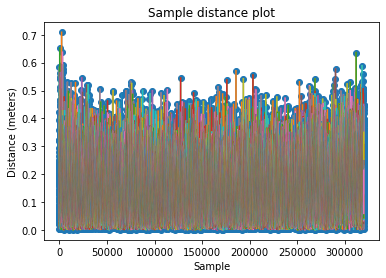

In [38]:
# Machine Learning - Make predictions

y_pred, theta_pred = model.predict(X_test)

y_pred_x = y_pred[:, 0]
y_pred_y = y_pred[:, 1]
y_pred_theta = theta_pred

# Round the predicted values to the nearest integer


# Combine the predicted x and y values into a single array of (x, y) tuples
y_pred = np.stack((y_pred_x, y_pred_y), axis=1)

# Calculate accuracy score
mse = metrics.mean_squared_error(Y_test[:, :2], y_pred)

print("Mean Error for test data (distance): ", math.sqrt(mse), "meters" )

mse = metrics.mean_squared_error(Y_test[:, 2], y_pred_theta)
print("Mean squared error for test data (degrees): ", math.sqrt(mse), "radians" )

print("#############################################################################################################")

err = tf.reduce_mean(tf.sqrt(tf.square(Y_test[:, 0] - y_pred[:, 0]) + tf.square(Y_test[:, 1] - y_pred[:, 1])))
print("Mean Error for test data (distance): ", err, "meters")


distance = (tf.sqrt(tf.square(Y_test[:, 0] - y_pred[:, 0]) + tf.square(Y_test[:, 1] - y_pred[:, 1])))

fig, ax = plt.subplots()

print(len(distance))

ax.scatter(range(len(distance)), distance)

ax.set_xlabel('Sample')
ax.set_ylabel('Distance (meters)')
ax.set_title('Sample distance plot')


# Show lines between adjacent samples
for i in range(len(distance)-1):
    ax.plot([i, i+1], [distance[i], distance[i+1]], )

# Show the plot
plt.show()


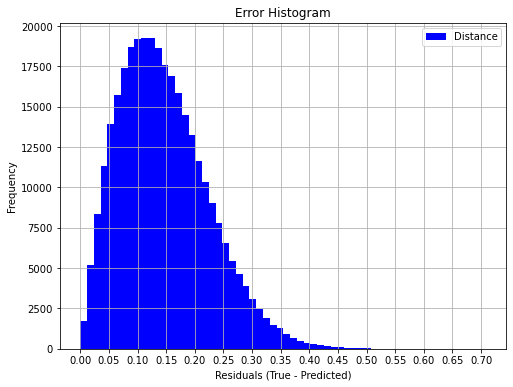

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Assuming residuals_x and residuals_y are calculated as shown in the previous example
plt.figure(figsize=(8, 6))
plt.hist(distance, bins=60, color='b', alpha=1, label='Distance')
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error Histogram')
# plt.grid(True)
# plt.show()

plt.gca().xaxis.set_major_locator(MultipleLocator(0.05))

plt.grid(True)
plt.show()

R-squared (R^2): 0.9911719952648101


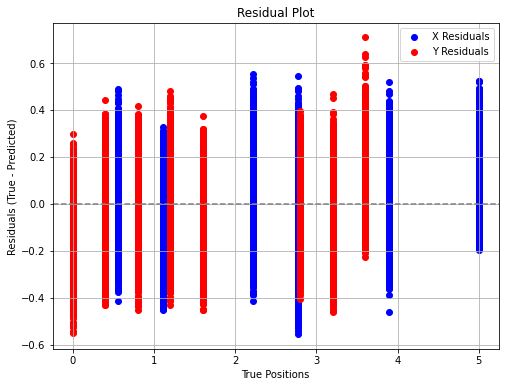

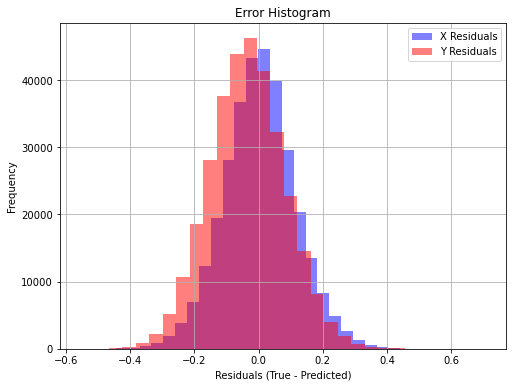

In [40]:
# Assuming y_true contains the true positions and y_pred contains the predicted positions
# Calculate the R-squared value
r_squared = r2_score(Y_test[:, :2], y_pred)

print("R-squared (R^2):", r_squared)

import matplotlib.pyplot as plt

# Assuming y_true contains the true positions and y_pred contains the predicted positions
residuals_x = Y_test[:, 0] - y_pred[:, 0]
residuals_y = Y_test[:, 1] - y_pred[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(Y_test[:, 0], residuals_x, c='b', label='X Residuals')
plt.scatter(Y_test[:, 1], residuals_y, c='r', label='Y Residuals')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('True Positions')
plt.ylabel('Residuals (True - Predicted)')
plt.legend()
plt.title('Residual Plot')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

# Assuming residuals_x and residuals_y are calculated as shown in the previous example
plt.figure(figsize=(8, 6))
plt.hist(residuals_x, bins=30, color='b', alpha=0.5, label='X Residuals')
plt.hist(residuals_y, bins=30, color='r', alpha=0.5, label='Y Residuals')
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error Histogram')
plt.grid(True)
plt.show()

# import seaborn as sns

# # Create separate density plots for true and predicted X positions
# plt.figure(figsize=(8, 6))
# sns.kdeplot(Y_test[:, 0], cmap='Blues', shade=True, label='True X Density')
# sns.kdeplot(y_pred[:, 0], cmap='Blues', shade=True, label='Predicted X Density')
# plt.xlabel('X Positions')
# plt.ylabel('Density')
# plt.legend()
# plt.title('Density Plot for X Positions')
# plt.grid(True)
# plt.show()

# # Create separate density plots for true and predicted Y positions
# plt.figure(figsize=(8, 6))
# sns.kdeplot(Y_test[:, 1], cmap='Reds', shade=True, label='True Y Density')
# sns.kdeplot(y_pred[:, 1], cmap='Reds', shade=True, label='Predicted Y Density')
# plt.xlabel('Y Positions')
# plt.ylabel('Density')
# plt.legend()
# plt.title('Density Plot for Y Positions')
# plt.grid(True)
# plt.show()

# import statsmodels.api as sm

# # Assuming residuals_x and residuals_y are calculated as shown earlier
# sm.qqplot(residuals_x, line='s', label='X Residuals', color='b')
# sm.qqplot(residuals_y, line='s', label='Y Residuals', color='r')
# plt.xlabel('Theoretical Quantiles')
# plt.ylabel('Sample Quantiles')
# plt.legend()
# plt.title('QQ Plot')
# plt.grid(True)
# plt.show()

# import seaborn as sns

# Create a DataFrame with true positions and predicted positions
# import pandas as pd
# df = pd.DataFrame({'True_X': Y_test[:, 0], 'True_Y': Y_test[:, 1], 'Predicted_X': y_pred[:, 0], 'Predicted_Y': y_pred[:, 1]})

# # Create a scatter plot matrix
# df = df.dropna()
# sns.pairplot(df)
# plt.title('Scatter Plot Matrix')
# plt.show()

10000/10000 [==============================] - 10s 967us/step
160000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


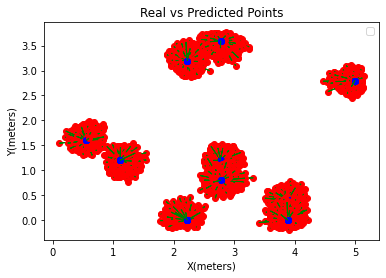

In [41]:

# Assume you have a trained model called "model"
# and a test set called X_test and y_test

# Make predictions on the test set
# y_pred, theta_pred = model.predict(X_test)

# Create a scatter plot showing the real points in blue
# plt.scatter(Y_test[:,0], Y_test[:,1], color='blue', label='Real Points')
y_pred, theta_pred = model.predict(X_test)

x_pred = y_pred[:, 0]
y_pred = y_pred[:, 1]

# Create a scatter plot showing the predicted points in red
# plt.scatter(x_pred, y_pred, color='red', label='Predicted Points')
number_for_plot = int(x_pred.shape[0]/2)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print(number_for_plot)
# Loop through each point in the test set
for i in range(0 , 20000):
    k = i * 16
    # percentage = (i/number_for_plot)*100
    # print(percentage)
    # Get the x and y coordinates for the real and predicted points
    x_real, y_real, theta_real = Y_test[k]
    x_pred_arrow = x_pred[k]
    y_pred_arrow = y_pred[k]
    plt.scatter(x_real, y_real, color='blue')
    plt.scatter(x_pred_arrow, y_pred_arrow, color='red')
    # Add an arrow from the real point to the predicted point
    plt.arrow(x_real, y_real, x_pred_arrow - x_real, y_pred_arrow - y_real, 
              length_includes_head=True, head_width=0.01, color='green')
    
# Set the x-axis label to "X"
plt.xlabel('X(meters)')

# Set the y-axis label to "Y"
plt.ylabel('Y(meters)')

# Set the title of the plot to "Real vs Predicted Points"
plt.title('Real vs Predicted Points')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [42]:
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")
#     plt.legend(loc="best")
#     return plt

In [43]:
# from sklearn.linear_model import LinearRegression

# # Create a LinearRegression object
# lr = LinearRegression()

# # Plot the learning curve
# plot_learning_curve(lr, "Linear Regression", X, Y, cv=5)
# plt.show()

# plt.savefig('plot.png')
# print('Break Point')


# plot_learning_curve(lr, "Linear Regression", X, Y, cv=5)
# plt.ylim(-5, 1.1)
# plt.show() 